# ERK-KTR Full FOV Stimulation Pipeline

## System Init

### Load pymmcore and required python libraries

In [23]:
import os
import time

os.environ['QT_LOGGING_RULES'] = '*.debug=false; *.warning=false' # Fix to suppress PyQT warnings from napari-micromanager when running in a Jupyter notebook
os.environ['MICROMANAGER_PATH'] = "C:\\Program Files\\Micro-Manager-2.0"

from fov import FOV
from useq import MDAEvent
import pandas as pd
import numpy as np
import random
import napari
import pymmcore_plus
from napari_micromanager import MainWindow

from utils import create_folders
from useq._mda_event import SLMImage

mmc = pymmcore_plus.CMMCorePlus()

### Device Specific Init for Niesen Microscope

In [24]:
mmc.loadSystemConfiguration("E:\\pertzlab_mic_configs\\micromanager\\\Jungfrau\\TiFluoroJungfrau_w_TTL_DIGITALIO.cfg")
mmc.setChannelGroup(channelGroup="TTL_ERK")

OSError: Line 69: Property,Core,Initialize,1
Error in device "Andor sCMOS Camera": Unable to communicate with the device. (35)



## GUI - Napari Micromanager

### Load GUI

In [25]:
### Base GUI ###
viewer = napari.Viewer()
mm_wdg = MainWindow(viewer)
viewer.window.add_dock_widget(mm_wdg)

In [4]:
### Add MDA widget for FOV selection ###
from pymmcore_widgets.mda import MDAWidget
mdawidget = MDAWidget(mmcore = mmc)
viewer.window.add_dock_widget(mdawidget)

### Functions to break and re-connect link with GUI if manually broken

The following functions can be used to manually interrupt to connection between the GUI and the running rtm-pymmcore script. However, normally you don't need to execute them. 

In [10]:
### Break connection
# mm_wdg._core_link.cleanup()

In [21]:
### Manually reconnect pymmcore with napari-micromanager
from napari_micromanager._core_link import CoreViewerLink
mm_wdg._core_link = CoreViewerLink(viewer, mmc)

## Create a DF with all planned acquisitions and stimulations

### Settings for Experiment

In [17]:
df_acquire = pd.DataFrame(columns=['fov', 'timestep', 'time','time_experiment', 'treatment', 'acquired','stim', 'channels', 'channel_stim'])

base_path = "\\\\izbkingston.unibe.ch\\imaging.data\\mic01-imaging\\Alex\\pymmcore\\"
experiment_name = "2025-03-10_TrKA1_FGFRhigh"
path  = os.path.join(base_path, experiment_name)

create_folders(path,['stim','raw','labels','stim_mask','tracks','labels_rings','particles'])

time_between_frames = 60 #time in seconds between frames
time_per_fov = 10 #time in seconds per fov

timesteps = range(60)  
channels = ['miRFP', 'mRuby'] #channel for segmentation first
channels_exposure = [200, 150]

# take values from UI, if loaded
intensity_red_laser = mmc.getProperty("Spectra", "Red_Level")
intensity_green_laser = mmc.getProperty("Spectra", "Green_Level")

if intensity_red_laser != str(0) and intensity_green_laser != str(0):
    channels_power = [intensity_red_laser, intensity_green_laser]
else:
    channels_power = [80, 30]
    for channel, power in zip(channels, channels_power):
        mmc.setProperty("Spectra", f"{channel.upper()}_Level", power)


# cell_lines = ["optoFGFR_high"] * 24 + ["optoFGFR"] * 24
cell_lines = ["optoTrkA1", "optoFGFR1_high"] 


stim_exposures = [0, 25, 50, 75, 100, 250] # list of possible exposures in ms
stim_timesteps = [[10]]  # list of timesteps for stimulation, if e.g. double stimulation in frame 0 and 1 is needed write [[0,1]]
stim_profiles = [{"device_name": "Spectra", "property_name": "Cyan_Level", "power": 5, "channel": "CyanStim"}]
stim_treatment = [{"stim_property": "global", "stim_profile": stim_profile, "stim_exposure": stim_exposure, "stim_timestep": stim_timestep} 
                  for stim_profile in stim_profiles for stim_exposure in stim_exposures for stim_timestep in stim_timesteps]

# if defining individual fovs, else these values a re ignored: 
n_fovs_per_cell_line = 24 ## change this variable to the amount of fovs that you have per cell line. If only one cell line is set, this value will 
                        # automatically set to total amount of fovs. If you are working will wellplate, this value will be ignored, as each columns
                        # will be an entry in the cell lines list. 

n_fovs_per_well = 4 ## change this variable to the amount of fovs that you have per well. Set to None if you are not working with wellplate.
                    # If you are working with the autogenetreated wellplate, this value will be ignored, as each columns will be an entry in the cell lines list.

data_mda_fovs = None
stim_treatment

Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-10_TrKA1_FGFRhigh\stim already exists
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-10_TrKA1_FGFRhigh\raw already exists
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-10_TrKA1_FGFRhigh\labels already exists
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-10_TrKA1_FGFRhigh\stim_mask already exists
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-10_TrKA1_FGFRhigh\tracks already exists
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-10_TrKA1_FGFRhigh\labels_rings already exists
Directory \\izbkingston.unibe.ch\imaging.data\mic01-imaging\Alex\pymmcore\2025-03-10_TrKA1_FGFRhigh\particles already exists


[{'stim_property': 'global',
  'stim_profile': {'device_name': 'Spectra',
   'property_name': 'Cyan_Level',
   'power': 5,
   'channel': 'CyanStim'},
  'stim_exposure': 0,
  'stim_timestep': [10]},
 {'stim_property': 'global',
  'stim_profile': {'device_name': 'Spectra',
   'property_name': 'Cyan_Level',
   'power': 5,
   'channel': 'CyanStim'},
  'stim_exposure': 25,
  'stim_timestep': [10]},
 {'stim_property': 'global',
  'stim_profile': {'device_name': 'Spectra',
   'property_name': 'Cyan_Level',
   'power': 5,
   'channel': 'CyanStim'},
  'stim_exposure': 50,
  'stim_timestep': [10]},
 {'stim_property': 'global',
  'stim_profile': {'device_name': 'Spectra',
   'property_name': 'Cyan_Level',
   'power': 5,
   'channel': 'CyanStim'},
  'stim_exposure': 75,
  'stim_timestep': [10]},
 {'stim_property': 'global',
  'stim_profile': {'device_name': 'Spectra',
   'property_name': 'Cyan_Level',
   'power': 5,
   'channel': 'CyanStim'},
  'stim_exposure': 100,
  'stim_timestep': [10]},
 {'st

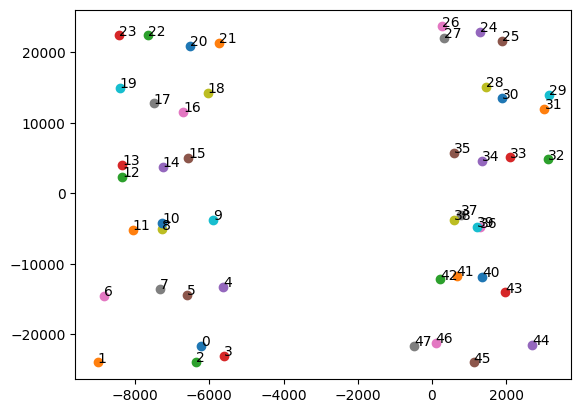

In [51]:
import matplotlib.pyplot as plt
plt.figure()
data_mda_fovs = mdawidget.value().stage_positions
i = 0
for fov_x_y in data_mda_fovs:
    plt.scatter(fov_x_y.x, fov_x_y.y, label=f'{fov_x_y.x},{fov_x_y.y}')
    plt.text(fov_x_y.x, fov_x_y.y, f'{i}')
    i+=1
plt.show()

### Map Experiment to FOVs

#### If FOVs already saved - Reload them from file

In [4]:
import json
file = os.path.join(path, "fovs.json")
with open(file, "r") as f:
    data_mda_fovs = json.load(f)

Only select one of the following two code blocks. If you autogenerated FOVs using the wellplate option of the MDA widget, then use the first code block, else the second. 

#### MDA Widget was used in wellplate mode with autogenerated FOVs

In [ ]:
random.shuffle(stim_treatment)
fovs:list[FOV] = []
if data_mda_fovs is None:
    data_mda_fovs = mdawidget.value()
n_fovs = len(data_mda_fovs.stage_positions)
pts_per_well = data_mda_fovs.stage_positions.well_points_plan.num_points
n_wells = n_fovs // pts_per_well

used_well_columns = []

for i, row in enumerate(data_mda_fovs.stage_positions):
    well_column = int(row.name.split('_')[0][1:])
    used_well_columns.append(well_column)

unique_well_columns = list(set(used_well_columns))
unique_well_column_translation = {col: idx for idx, col in enumerate(unique_well_columns)}
  

for i, row in enumerate(data_mda_fovs.stage_positions):
    well_row = row.name.split('_')[0][0]
    well_id = i%pts_per_well
    if len(cell_lines) == 1:
        cell_line = cell_lines[0]
    else: 
        cell_line = cell_lines[unique_well_column_translation[well_column]]
    fov = FOV(pos=(row.x, row.y),
              index=i,
              name=row.name,
              path=path,
              metadata={"well_column": well_column, "well_row": well_row, "well_id": well_id, "cell_line": cell_line},
              treatment=stim_treatment[i%len(stim_treatment)],
              )
    fovs.append(fov)

#### FOVs were manually selected using MDA widget

In [18]:
fovs:list[FOV] = []
if data_mda_fovs is None:
    data_mda_fovs = mdawidget.value().stage_positions
n_fovs = len(data_mda_fovs)
n_stim_treatments = len(stim_treatment)
n_fovs_per_stim_condition = n_fovs // n_stim_treatments // len(np.unique(cell_lines))


stim_treatment_tot = []
random.shuffle(stim_treatment)
if n_fovs_per_well is not None: 
    for stim_treat in stim_treatment: 
        stim_treatment_tot.extend([stim_treat] * n_fovs_per_well)

else:
    for i in range(0, n_fovs_per_stim_condition): 
        stim_treatment_tot.extend(stim_treatment)
    random.shuffle(stim_treatment_tot)

    if n_fovs % n_stim_treatments != 0:
        print(f"Warning: Not equal number of fovs per stim condition. {n_fovs % n_stim_treatments} fovs will have repeated treatment")
        stim_treatment_tot.extend(stim_treatment[:n_fovs % n_stim_treatments])

if len(cell_lines) == 1: 
    n_fovs_per_cell_line = n_fovs
else: 
    stim_treatment_tot = stim_treatment_tot * len(np.unique(cell_lines))

 

for i, row in enumerate(data_mda_fovs):
    row = dict(row)
    if len(cell_lines) == 1:
        cell_line = cell_lines[0]
    else:
        cell_line = cell_lines[i // n_fovs_per_cell_line]
    fov = FOV(pos=(row["x"], row["y"]),
              index=i,
              name=str(i),
              path=path,
              metadata={"cell_line": cell_line},
              treatment=stim_treatment_tot[i],
              )
    fovs.append(fov)

print(f"Doing {n_fovs_per_stim_condition} replicates per stim condition")

Doing 4 replicates per stim condition


### Use FOVs to generate dataframe for acquisition

In [19]:
n_fovs_simultaneously = time_between_frames // time_per_fov
start_time = 0

dfs = []
for fov in fovs:
    fov_group = fov.index // n_fovs_simultaneously
    start_time = fov_group * time_between_frames * len(timesteps)

    for timestep in timesteps:
        new_row = { 'fov_object': fov,
                    'fov':fov.index,
                    'name':fov.name,
                    'timestep': timestep,
                    'time': start_time + timestep*time_between_frames,
                    'treatment': fov.treatment,
                    'metadata': fov.metadata,
                    'stim': timestep in fov.treatment['stim_timestep'] and fov.treatment["stim_exposure"] != 0, # not really important, only for visualisation
                    'channels': channels,
                    'channels_exposure':channels_exposure,
                    'channel_power': channels_power,
                    'stim_exposure' : fov.treatment['stim_exposure'], # not really important, only for visualisation
                    'fname' : f'{str(fov.index).zfill(3)}_{str(timestep).zfill(5)}',
                    }
        dfs.append(new_row)

df_acquire = pd.DataFrame(dfs)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)
df_acquire = df_acquire.sort_values(by=['time', 'fov'])
print(f"Total Experiment Time: {df_acquire['time'].max()/3600}h")
df_acquire


Total Experiment Time: 7.983333333333333h


,fov_object,fov,name,timestep,time,treatment,metadata,stim,channels,channels_exposure,channel_power,stim_exposure,fname
0,<fov.FOV object at 0x0000017C92FEC040>,0,0,0,0,"{'stim_property': 'global', 'stim_profile': {'...",{'cell_line': 'optoTrkA1'},False,"[miRFP, mRuby]","[200, 150]","[80, 30]",0,000_00000
60,<fov.FOV object at 0x0000017C92FEC070>,1,1,0,0,"{'stim_property': 'global', 'stim_profile': {'...",{'cell_line': 'optoTrkA1'},False,"[miRFP, mRuby]","[200, 150]","[80, 30]",0,001_00000
120,<fov.FOV object at 0x0000017C92FED090>,2,2,0,0,"{'stim_property': 'global', 'stim_profile': {'...",{'cell_line': 'optoTrkA1'},False,"[miRFP, mRuby]","[200, 150]","[80, 30]",0,002_00000
180,<fov.FOV object at 0x0000017C92FECFA0>,3,3,0,0,"{'stim_property': 'global', 'stim_profile': {'...",{'cell_line': 'optoTrkA1'},False,"[miRFP, mRuby]","[200, 150]","[80, 30]",0,003_00000
240,<fov.FOV object at 0x0000017C92FECFD0>,4,4,0,0,"{'stim_property': 'global', 'stim_profile': {'...",{'cell_line': 'optoTrkA1'},False,"[miRFP, mRuby]","[200, 150]","[80, 30]",100,004_00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,<fov.FOV object at 0x0000017C92FEC670>,43,43,59,28740,"{'stim_property': 'global', 'stim_profile': {'...",{'cell_line': 'optoFGFR1_high'},False,"[miRFP, mRuby]","[200, 150]","[80, 30]",75,043_00059
2699,<fov.FOV object at 0x0000017C92FEE980>,44,44,59,28740,"{'stim_property': 'global', 'stim_profile': {'...",{'cell_line': 'optoFGFR1_high'},False,"[miRFP, mRuby]","[200, 150]","[80, 30]",25,044_00059
2759,<fov.FOV object at 0x0000017C92FEE860>,45,45,59,28740,"{'stim_property': 'global', 'stim_profile': {'...",{'cell_line': 'optoFGFR1_high'},False,"[miRFP, mRuby]","[200, 150]","[80, 30]",25,045_00059
2819,<fov.FOV object at 0x0000017C92FEE830>,46,46,59,28740,"{'stim_property': 'global', 'stim_profile': {'...",{'cell_line': 'optoFGFR1_high'},False,"[miRFP, mRuby]","[200, 150]","[80, 30]",25,046_00059


## Run experiment

In [ ]:
%load_ext autoreload
%autoreload 2

SLEEP_TIME_IN_HOURS = 0

for _ in range(0, SLEEP_TIME_IN_HOURS*3600): 
    time.sleep(1)
from add_frame import ImageProcessingPipeline
from segmentation_stardist import SegmentatorStardist
from stimulation import StimWholeFOV    
from controller import Controller, Analyzer
from tracking_trackpy import TrackerTrackpy
from dmd import DMD
from queue import Queue

try: 
    mm_wdg._core_link.cleanup()
except:
    pass

segmentator = SegmentatorStardist(min_size=200, prob_thresh=0.55)
stimulator = StimWholeFOV()
tracker = TrackerTrackpy()

pipeline = ImageProcessingPipeline(segmentator,stimulator,tracker)
analyzer = Analyzer(pipeline)
queue = Queue()
controller = Controller(analyzer, mmc, queue)
controller.run(df_acquire)
